 # Collaborative Latent-Factors-Based Filtering for Movie Recommendations (Incomplete)

## Introduction

The latent factor approach in recommendation systems utilizes matrix factorization techniques to uncover hidden patterns in user-item interactions. These methods predict user preferences by mapping both users and items to a shared latent space where their interactions can be represented by their proximity or alignment. Latent factor models, such as Singular Value Decomposition (SVD), are widely used in this context.

Key features of the latent factor approach:
- Captures underlying relationships between users and items.
- Handles sparse datasets effectively by reducing dimensionality.
- Improves scalability compared to neighborhood-based methods.

In this notebook, we will explore the latent factor approach to build a movie recommendation system using matrix factorization.

### Mathematical Background

The latent factor approach works by:
- Represent users and items in a shared lower dimensional latent space (i.e., as a vector of latent factors).
- Such vectros are inferred (i.e., learned) from the observed ratings.
- High correlation between user and item latent factors indicates a possible recomendation.
- Map both users and items to the latent space and then predict ratings based on the inner product in the latent space.

So formally we have:
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $\vec x_u \in R^d$ is the latent factor vector for user $u$. Each $\vec x_u[k] \in R$ measure the extent of interest user $u$ has in items exhibiting latent factor $k$.
- $\vec w_i \in R^d$ is the latent factor vector for item $i$. Each $\vec w_i[k] \in R$ measure the extent of interest item $i$ has in users exhibiting latent factor $k$.

Essentially, $d$ hidden features to describe both users and items.

Thus, $r_{u,i}$ is the rating given by user $u$ to item $i$ and $\hat{r}_{u,i} = \vec x_u \cdot \vec w_i = \sum_{k=1}^d \vec x_u[k] \cdot \vec w_i[k]$ is the predicted rating for user $u$ and item $i$.

The problem is to approximate the user-item matrix $M \in \mathbb R^{n \times m}$ with the product of a user latent factor matrix $X \in \mathbb R^{n \times d}$ and an item latent factor matrix $W^T \in \mathbb R^{d \times m}$. So

$$
M \approx X \cdot W^T.
$$

## Dataset Description

We use two datasets for this analysis:

1. **Movies Dataset**:
   - `Movie_ID`: Unique identifier for each movie.
   - `Title`: Name of the movie.
   - `Year`: Year the movie was released.

2. **Ratings Dataset**:
   - `User_ID`: Unique identifier for each user.
   - `Movie_ID`: Identifier for the movie rated by the user.
   - `Rating`: Numeric rating provided by the user (e.g., on a scale of 1-5).

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Load the dataset
ratings = pd.read_csv("./data/Netflix_Dataset_Rating.csv")  # Columns: User_ID, Rating, Movie_ID
movies  = pd.read_csv("./data/Netflix_Dataset_Movie.csv")    # Columns: Movie_ID, Year, Name

### Formal Definition

- $U = \{u_1, u_2, \dots, u_n\}$ is the set of users.
- $U_i = \{u \in U \mid r_{u,i} \neq 0\}$ is the set of users who have rated item $i$
- $I = \{i_1, i_2, \dots, i_m\}$ is the set of items.
- $I_u = \{i \in I \mid r_{u,i} \neq 0\}$ is the set of items rated by user $u$
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $r_{u,i}$ is the rating given by user $u$ for item $i$ (equal to 0 if not rated).
- $D = \{(u_j, i_j)\}_{j=1}^{N}$ is the set of user-item pairs (our dataset).
- $I_D = \{i \in I \mid \exists (u, i) \in D\}$ is the set of items in the dataset.
- $U_D = \{u \in U \mid \exists (u, i) \in D\}$ is the set of users in the dataset.

## User-Based Collaborative Filtering

### 1. Data Preprocessing
- **User-Item Matrix Creation**: Convert the ratings dataset into a user-item matrix, where rows represent users and columns represent movies. Missing ratings are filled with zeros. Each rating is represented by a number from 1 to 5.
  $$ M[u, i] = r_{u,i} \in R$$
  Where:
  - $u \in U$
  - $i \in I$
  - $r_{u,i}$ is the rating given by user $u$ for movie $i$.

- **Sparse Matrix Conversion**: The dense matrix is converted to a sparse format for memory optimization:
  $$M_{\{\text{sparse}\}} = \text{sparse}(M)$$

In [2]:
# Step 1: Create a user-item matrix
user_item_matrix = ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating')

# Fill missing values with 0 (can use NaN for some algorithms)
user_item_matrix.fillna(0, inplace=True) # It is not the case for this dataset

# Convert the DataFrame to a sparse matrix
sparse_user_item = csr_matrix(user_item_matrix.values)

### 2. Determine the Loss Function and Computing Its Gradient

Assuming we have access to the dataset $D$ of observed ratings, the matrix $M$ is partially known and filled with those observations. To actually learn the latent factors, we need to choose a loss function to optimize. In our case, we choose squared error (SE):

$$
L(X, W) = \frac{1}{2} \left[ \sum_{(u, i) \in D} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda (\sum_{u \in U_D} \|\vec x_u\|^2 + \sum_{i \in I_D} \|\vec w_i\|^2)\right]
$$

Thus, 

$$X^*, W^* = \argmin_{X, W} \ L(X, W).$$

#### Loss Function
The loss function in matrix notation is defined in terms of matrices as:
$$
L(X, W) = \frac{1}{2} \left[ \| M - X W^T \|_F^2 + \lambda \left( \|X\|_F^2 + \|W\|_F^2 \right) \right],
$$
where:
- $M \in \mathbb{R}^{n \times m}$ is the observed rating matrix, with $M_{u,i} = r_{u,i}$ if user $u$ has rated item $i$, and 0 otherwise.
- $X \in \mathbb{R}^{n \times d}$ represents the user latent factors (each row corresponds to a user vector $X_u$).
- $W \in \mathbb{R}^{m \times d}$ represents the item latent factors (each row corresponds to an item vector $W_i$).
- $\| \cdot \|_F$ is the Frobenius norm.

The prediction matrix is:
$$
\hat{M} = X W^T.
$$

The loss consists of:
1. The reconstruction error:
$$
\| M - X W^T \|_F^2 = \sum_{(u, i) \in D} (r_{u,i} - X_u W_i^T)^2.
$$
2. The regularization terms:
$$
\lambda \left( \|X\|_F^2 + \|W\|_F^2 \right).
$$

---

#### Computing the Gradients

##### Gradient with respect to $X$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial X} \frac{1}{2} \| M - X W^T \|_F^2 = -(M - X W^T) W.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial X} \frac{\lambda}{2} \|X\|_F^2 = \lambda X.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial X} = -(M - X W^T) W + \lambda X.
$$

---

##### Gradient with respect to $W$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial W} \frac{1}{2} \| M - X W^T \|_F^2 = -(M - X W^T)^T X.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial W} \frac{\lambda}{2} \|W\|_F^2 = \lambda W.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial W} = -(M - X W^T)^T X + \lambda W.
$$

In [3]:
# Step 2: Setting up the model parameters

# Hyperparameters
num_factors = 250  # Number of latent factors (k)
learning_rate = 0.001  # Learning rate (eta)
reg_lambda = 0.0001  # Regularization term (lambda)
num_epochs = 25  # Number of epochs
gradient_clip = 10.0  # Gradient clipping threshold

# Dimensions of the user-item matrix
num_users, num_items = user_item_matrix.shape

# Initialize latent factor matrices X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# Create a mask for observed entries in R
M = user_item_matrix.values 
mask = M > 0  # Boolean mask for observed entries

# List to store loss values for plotting
loss_history = []

### 3. Optimize the Loss Function with Stochastic Gradient Descent

In order to optimize the loss function, we use Stochastic Gradient Descent (SGD).

#### Explanation of the SGD Algorithm (Matrix Form)

##### 1. Initialization
- Matrices $X$ (users' latent factors) and $W$ (items' latent factors) are initialized randomly with small values.
- $X \in \mathbb{R}^{m \times d}$, where $m$ is the number of users and $d$ is the number of latent factors.
- $W \in \mathbb{R}^{n \times d}$, where $n$ is the number of items.

##### 2. Gradient Computation
- Define the prediction matrix:
  $$
  \hat{M} = X W^T
  $$
- Compute the error matrix (only for observed entries in $M$):
  $$
  E = \begin{cases}
  M_{ui} - \hat{M}_{ui} \quad &\text{if} \ M_{ui} > 0\\
  0 \quad &\text{otherwise}
  \end{cases},
  $$
  where $E_{ui} = 0$ for unobserved entries of $M$.

- Gradients for $X$ and $W$:
  $$
  \nabla_X = - E W + \lambda X
  $$
  $$
  \nabla_W = - E^T X + \lambda W
  $$

##### 3. Updates
- Update the latent factor matrices $X$ and $W$ simultaneously:
  $$
  X \leftarrow X - \eta \nabla_X
  $$
  $$
  W \leftarrow W - \eta \nabla_W
  $$
- Here, $\eta$ is the learning rate.

##### 4. Loss Tracking
- The total loss for each epoch combines the squared error and the regularization terms:
  $$
  L = \| M - X W^T \|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
  $$
- This tracks the reconstruction error and ensures that the latent factor matrices do not grow too large (controlled by the regularization term).

##### 5. Optimization Loop
- Repeat the following steps for a fixed number of epochs or until the loss converges:
  1. Compute the error matrix $E$.
  2. Compute the gradients $\nabla_X$ and $\nabla_W$ using matrix operations.
  3. Update $X$ and $W$ using the gradients.
  4. Track and print the loss for each epoch.

---

##### Notes
- This implementation only updates $X$ and $W$ for the observed entries of $M$ using matrix masking.
- The hyperparameters ($\eta$, $d$, and $\lambda$) should be tuned based on the dataset for optimal performance.

In [4]:
#4. Start SGD loop

# Initialize M_hat as the predicted matrix
M_hat = np.ndarray(shape=(num_users, num_items))

# Perform SGD for a number of epochs

for epoch in range(num_epochs):
    # Compute the predicted matrix
    M_hat = X @ W.T

    # Compute the error matrix for observed entries only
    E = np.multiply(mask, M - M_hat)

    # Compute gradients with regularization
    grad_X = -E @ W + reg_lambda * X
    grad_W = -E.T @ X + reg_lambda * W

    # Apply gradient clipping to avoid exploding updates
    grad_X = np.clip(grad_X, -gradient_clip, gradient_clip)
    grad_W = np.clip(grad_W, -gradient_clip, gradient_clip)

    # Update X and W
    X -= learning_rate * grad_X
    W -= learning_rate * grad_W

    # Compute the total loss
    reconstruction_loss = np.sum(np.multiply(mask, E) ** 2)
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss

    # Append the total loss to the history
    loss_history.append(total_loss)

    # Print the loss for the current epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

    # Check for NaN or Inf values in X or W
    if np.any(np.isnan(X)) or np.any(np.isnan(W)) or np.any(np.isinf(X)) or np.any(np.isinf(W)):
        print("Numerical instability detected. Terminating training.")
        break

    # Debugging: Check mean and std of gradients
    print(f"  Gradient X: mean={np.mean(grad_X):.4f}, std={np.std(grad_X):.4f}")
    print(f"  Gradient W: mean={np.mean(grad_W):.4f}, std={np.std(grad_W):.4f}")

Epoch 1/25
  Reconstruction Loss: 243096443.3037
  Regularization Loss: 0.3623
  Total Loss: 243096443.6660
  Gradient X: mean=0.0077, std=0.4150
  Gradient W: mean=-0.0823, std=3.6455
Epoch 2/25
  Reconstruction Loss: 243085588.2208
  Regularization Loss: 0.3640
  Total Loss: 243085588.5848
  Gradient X: mean=-0.0389, std=0.8452
  Gradient W: mean=0.0466, std=5.2258
Epoch 3/25
  Reconstruction Loss: 243022754.1014
  Regularization Loss: 0.3729
  Total Loss: 243022754.4743
  Gradient X: mean=-0.0426, std=2.1268
  Gradient W: mean=-0.3657, std=7.5047
Epoch 4/25
  Reconstruction Loss: 242668486.6514
  Regularization Loss: 0.4090
  Total Loss: 242668487.0604
  Gradient X: mean=-0.1634, std=3.8837
  Gradient W: mean=-0.2031, std=9.1671
Epoch 5/25
  Reconstruction Loss: 241588463.8133
  Regularization Loss: 0.5041
  Total Loss: 241588464.3174
  Gradient X: mean=-0.2049, std=5.4751
  Gradient W: mean=-0.4861, std=9.6866
Epoch 6/25
  Reconstruction Loss: 239412121.5275
  Regularization Loss: 

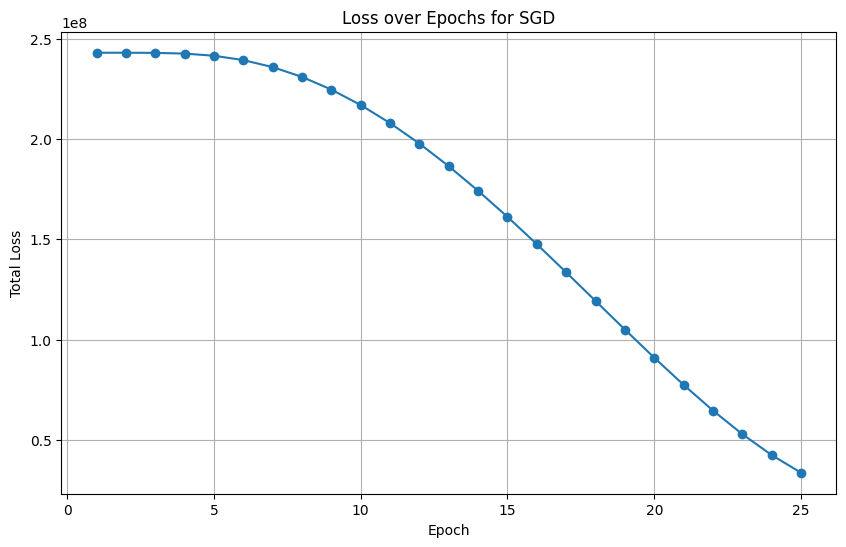

In [6]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs for SGD')
plt.grid()
plt.show()

### Optimize the Loss Function with Alternating Least Squares (ALS)

Alternating Least Squares (ALS) is an optimization method for matrix factorization that alternates between updating the user latent factors ($X$) and the item latent factors ($W$).

#### Objective
The goal is to minimize the following loss function:
$$
L(X, W) = \|M - XW^T\|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
$$
Where:
- $M$: User-item interaction matrix.
- $X$: User latent factor matrix ($m \times k$).
- $W$: Item latent factor matrix ($n \times k$).
- $\lambda$: Regularization parameter.

#### ALS Algorithm
1. **Initialization**:
   - Start with random values for $X$ and $W$.
2. **Alternating Updates**:
   - Fix $W$, solve for $X$:
     $$
     X_u = (W^T W + \lambda I)^{-1} W^T M_u
     $$
   - Fix $X$, solve for $W$:
     $$
     W_i = (X^T X + \lambda I)^{-1} X^T M_i
     $$
3. **Convergence**:
   - Iterate until the loss stabilizes or a set number of epochs is reached.

In [8]:
from tqdm import tqdm

# Regularization parameter
reg_lambda = 0.1

# Initialize X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# List to store the loss values for each iteration
loss_history = []

# ALS iterations
for iteration in range(num_epochs):
    print(f"Iteration {iteration + 1}/{num_epochs}")
    
    # Update X by fixing W
    for u in tqdm(range(num_users), desc="Updating X", leave=False):
        rated_items = mask[u, :]  # Mask for items rated by user u
        W_rated = W[rated_items, :]
        M_rated = M[u, rated_items]
        
        # Solve for X_u
        A = W_rated.T @ W_rated + reg_lambda * np.eye(num_factors)
        b = W_rated.T @ M_rated
        X[u, :] = np.linalg.solve(A, b)
    
    # Update W by fixing X
    for i in tqdm(range(num_items), desc="Updating W", leave=False):
        rated_users = mask[:, i]  # Mask for users who rated item i
        X_rated = X[rated_users, :]
        M_rated = M[rated_users, i]
        
        # Solve for W_i
        A = X_rated.T @ X_rated + reg_lambda * np.eye(num_factors)
        b = X_rated.T @ M_rated
        W[i, :] = np.linalg.solve(A, b)
    
    # Compute the loss
    M_hat = X @ W.T
    reconstruction_loss = np.sum(np.multiply(mask, (M - M_hat) ** 2))
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss
    
    # Save the loss in history
    loss_history.append(total_loss)
    
    # Print loss for the current iteration
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

Iteration 1/25


KeyboardInterrupt: 

In [9]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm  # Per la barra di avanzamento

# Regularization parameter
reg_lambda = 0.1

# Initialize X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# List to store the loss values for each iteration
loss_history = []

def update_user(u, W, M, mask, reg_lambda, num_factors):
    """Update a single user's latent factors."""
    rated_items = mask[u, :]  # Mask for items rated by user u
    W_rated = W[rated_items, :]
    M_rated = M[u, rated_items]
    
    A = W_rated.T @ W_rated + reg_lambda * np.eye(num_factors)
    b = W_rated.T @ M_rated
    return np.linalg.solve(A, b)

def update_item(i, X, M, mask, reg_lambda, num_factors):
    """Update a single item's latent factors."""
    rated_users = mask[:, i]  # Mask for users who rated item i
    X_rated = X[rated_users, :]
    M_rated = M[rated_users, i]
    
    A = X_rated.T @ X_rated + reg_lambda * np.eye(num_factors)
    b = X_rated.T @ M_rated
    return np.linalg.solve(A, b)

# ALS iterations
for iteration in range(num_epochs):
    print(f"Iteration {iteration + 1}/{num_epochs}")
    
    # Update X by fixing W (Parallelized)
    X = np.array(Parallel(n_jobs=-1)(delayed(update_user)(u, W, M, mask, reg_lambda, num_factors)
                                     for u in tqdm(range(num_users), desc="Updating X", leave=False)))
    
    # Update W by fixing X (Parallelized)
    W = np.array(Parallel(n_jobs=-1)(delayed(update_item)(i, X, M, mask, reg_lambda, num_factors)
                                     for i in tqdm(range(num_items), desc="Updating W", leave=False)))
    
    # Compute the loss
    M_hat = X @ W.T
    reconstruction_loss = np.sum(np.multiply(mask, (M - M_hat) ** 2))
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss
    
    # Save the loss in history
    loss_history.append(total_loss)
    
    # Print loss for the current iteration
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

Iteration 1/25


  Reconstruction Loss: 14209354.5993
  Regularization Loss: 32646013.5623
  Total Loss: 46855368.1616
Iteration 2/25


  Reconstruction Loss: 1930970.9705
  Regularization Loss: 13301795.5319
  Total Loss: 15232766.5023
Iteration 3/25


  Reconstruction Loss: 1080141.3410
  Regularization Loss: 11073631.2436
  Total Loss: 12153772.5846
Iteration 4/25


  Reconstruction Loss: 844501.7577
  Regularization Loss: 9655167.7194
  Total Loss: 10499669.4771
Iteration 5/25


  Reconstruction Loss: 718022.5975
  Regularization Loss: 8659682.9865
  Total Loss: 9377705.5840
Iteration 6/25


  Reconstruction Loss: 637268.5822
  Regularization Loss: 7902342.9704
  Total Loss: 8539611.5526
Iteration 7/25


Updating X:   7%|▋         | 9736/143458 [00:07<01:37, 1371.74it/s]

KeyboardInterrupt: 

In [6]:
def recommend_movies(user_id, M_hat, user_item_matrix, movies, top_n=10):
    """
    Recommends movies for a given user based on the predicted matrix M_hat.

    Parameters:
    - user_id: ID of the user to whom the recommendations will be made.
    - M_hat: Predicted user-item matrix (num_users x num_items).
    - user_item_matrix: Original user-item matrix (Pandas DataFrame) with ratings.
    - movies: DataFrame containing movie details (Movie_ID, Name, Year).
    - top_n: Number of recommendations to return (default is 10).

    Returns:
    - recommendations: DataFrame containing the top_n recommended movies.
    """
    # Map user_id to the corresponding index in M_hat
    user_index = user_item_matrix.index.get_loc(user_id)
    
    # Get the predicted ratings for the user
    predicted_ratings = M_hat[user_index]

    # Get the user's original ratings
    original_ratings = user_item_matrix.loc[user_id]

    # Find movies that the user has not rated (those with a rating of 0)
    unrated_movies = original_ratings[original_ratings == 0].index

    # Map the unrated movies to the correct columns in M_hat
    unrated_predictions = {
        movie_id: predicted_ratings[user_item_matrix.columns.get_loc(movie_id)]
        for movie_id in unrated_movies
    }

    # Sort the predicted ratings for unrated movies in descending order
    sorted_predictions = sorted(unrated_predictions.items(), key=lambda x: x[1], reverse=True)

    # Get the top_n movie IDs
    top_movie_ids = [movie_id for movie_id, _ in sorted_predictions[:top_n]]

    # Retrieve movie details for the top_n recommendations
    recommendations = movies[movies['Movie_ID'].isin(top_movie_ids)]

    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    recommendations = recommendations.copy()
    
    # Add the Predicted_Rating column
    recommendations['Predicted_Rating'] = [unrated_predictions[movie_id] for movie_id in recommendations['Movie_ID']]
    
    # Sort recommendations by predicted rating (optional, for clarity)
    recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False)

    return recommendations[['Movie_ID', 'Name', 'Year', 'Predicted_Rating']]

### 4. Model Testing
The function is tested with a sample user to generate personalized recommendations.

In [13]:
# Step 4: Test the recommendation function
user_id_to_test = 774868  # Cambia con un ID utente valido nel dataset
num_recommendations = 5   # Numero di raccomandazioni desiderate

try:
    # Esegui la funzione di raccomandazione
    recommendations = recommend_movies(user_id_to_test, M_hat, user_item_matrix, movies, top_n=num_recommendations)
    
    # Mostra i risultati
    print(f"Top {num_recommendations} movie recommendations for User {user_id_to_test}:")
    print(recommendations[['Name', 'Year', 'Predicted_Rating', 'Movie_ID']])
except KeyError as e:
    print(f"Error: User ID {user_id_to_test} not found in the dataset.")
except ValueError as e:
    print(f"Error: {e}")

Top 5 movie recommendations for User 774868:
                                       Name  Year  Predicted_Rating  Movie_ID
2113                                Firefly  2002          5.917396      2114
3045      The Simpsons: Treehouse of Horror  1990          5.825943      3046
3443  Family Guy: Freakin' Sweet Collection  2004          5.824890      3444
4237                              Inu-Yasha  2000          5.817704      4238
2056     Buffy the Vampire Slayer: Season 6  2001          5.816484      2057
